In [2]:
#### Capstone Project: Predicting Technician Actions Using Work Orders ####

### This notebook walks through the process of cleaning real-world technician notes, clustering similar behaviors, and building a ML model.
### Trained to predict the most likely technician action given a new breakdown or work order description.
### The goal is to create a foundation for an app that assists maintenance teams by recommending likely fixes based on historical patterns.

import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("Work Orders with description, and notes.csv", 
                 encoding='ISO-8859-1', 
                 dtype=str, 
                 low_memory=False)

# Basic cleanup
df = df.dropna(how='all')
df = df[df['WO No.'].astype(str).str.match(r'^\d+$')]
df['WO No.'] = df['WO No.'].astype(str).str.strip()
df['Description'] = df['Description'].astype(str).str.strip()
df['Text'] = df['Text'].astype(str).str.strip()
df = df[~((df['Description'].str.strip() == "") & (df['Text'].str.strip() == ""))]
df = df[df['Text'].notna() & (df['Text'].str.strip() != "") & (df['Text'].str.lower().str.strip() != "nan")]
df['Description_cleaned'] = df['Description'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.strip()
df['Text_cleaned'] = df['Text'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.strip()


In [5]:
### Cluster Technician Notes Using KMeans ###

# In this step, the cleaned technician notes were converted into numerical representations using TF-IDF (Term Frequency–Inverse Document Frequency). 
# This helps the model understand which words are important in each note.
# Then apply KMeans clustering to group similar notes into 5 behavior-based clusters. 
# Each cluster represents a type of technician response (e.g., reset, replace, inspect). 
# These clusters act as labels for training a ML model later.
# `TfidfVectorizer`: Converts text into a matrix of weighted word counts.
# `KMeans`: Automatically finds groups of similar notes without needing labeled data.
# The result is a new column in our dataset called `Note_Cluster`, which assigns each note to a group (0–4).

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

tfidf = TfidfVectorizer(stop_words='english')
X_notes = tfidf.fit_transform(df['Text_cleaned'])

kmeans = KMeans(n_clusters=5, random_state=42)
df['Note_Cluster'] = kmeans.fit_predict(X_notes)


In [6]:
#Top 10 words per cluster for understanding model interpretation

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Reset index to align row numbers with TF-IDF matrix
df_reset = df.reset_index(drop=True)

# Fit TF-IDF
text_data = df_reset['Text_cleaned']
clusters = df_reset['Note_Cluster']

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(text_data)
feature_names = np.array(tfidf.get_feature_names_out())

# Show top words per cluster
top_n = 10
for cluster in sorted(clusters.unique()):
    print(f"\n--- Top {top_n} Words for Cluster {cluster} ---")
    
    cluster_mask = clusters == cluster
    cluster_tfidf = X[cluster_mask]
    
    # Get average TF-IDF scores
    mean_tfidf = cluster_tfidf.mean(axis=0).A1
    top_indices = mean_tfidf.argsort()[::-1][:top_n]
    top_words = feature_names[top_indices]
    
    print(", ".join(top_words))



--- Top 10 Words for Cluster 0 ---
completed, brad, adjusted, reset, new, fox, curt, cleaned, installed, switch

--- Top 10 Words for Cluster 1 ---
replaced, brad, fuse, fox, torch, switch, belt, hose, line, air

--- Top 10 Words for Cluster 2 ---
complete, brad, md, chad, jeff, js, fred, bradjeff, cliff, joel

--- Top 10 Words for Cluster 3 ---
broken, replaced, wire, repaired, removed, bolt, springs, bolts, payne, spring

--- Top 10 Words for Cluster 4 ---
repaired, wiring, brad, chad, air, line, leak, fox, dale, wfox


In [7]:
### Train a Classification Model to Predict Technician Clusters ###

# Cleaned work order descriptions were used to train a supervised machine learning model.
# The goal is to predict which behavior-based cluster (`Note_Cluster`) a description belongs to.
# This turns the unsupervised clustering into a usable prediction tool for future work orders.
# `train_test_split`: Splits the data into 80% for training and 20% for testing.
# `TfidfVectorizer`: Transforms the text descriptions into numerical features.
# `LogisticRegression`: Learns the mapping between description features and the assigned cluster labels.
# `Pipeline`: Wraps the vectorizer and classifier into one reusable modeling pipeline.
# `classification_report`: Outputs precision, recall, and F1-score for each predicted cluster.
# The result shows how well the model performs and provides a baseline for future improvements.

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = df['Description_cleaned']
y = df['Note_Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.76      0.96      0.85      8250
           1       0.47      0.19      0.27      2096
           2       1.00      0.01      0.02       282
           3       0.38      0.05      0.09       287
           4       0.27      0.03      0.06       388

    accuracy                           0.74     11303
   macro avg       0.58      0.25      0.26     11303
weighted avg       0.69      0.74      0.67     11303



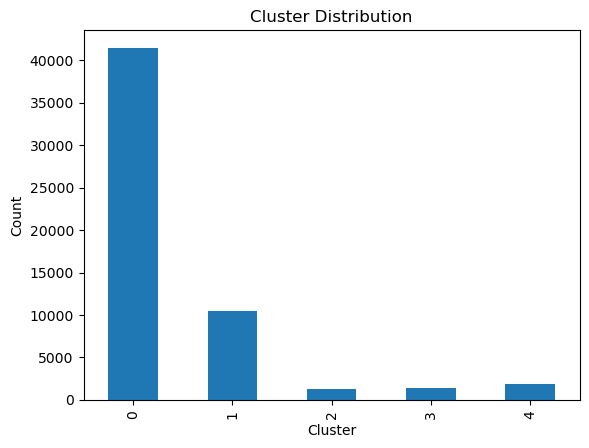

In [8]:
#Cluster Distribution Chart
import matplotlib.pyplot as plt
df['Note_Cluster'].value_counts().sort_index().plot(kind='bar', title='Cluster Distribution', xlabel='Cluster', ylabel='Count')
plt.show()

In [9]:
### The ML workflow ### 
# Fitting the TfidfVectorizer to the text in X_train
# Transforms X_train into a TF-IDF matrix
# Trains the logistic regression model using that matrix and y_train labels

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression(max_iter=1000))])

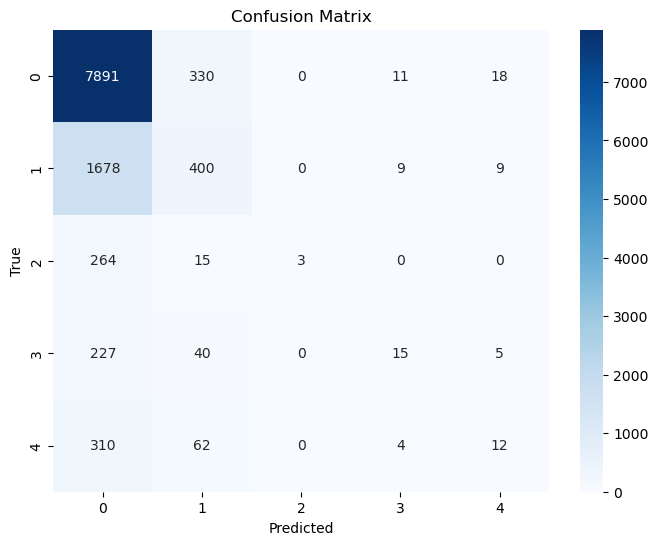

In [10]:
### Confusion Matrix ### 
#This matrix evaluates the performance of the logistic regression model used to predict technician note clusters based on descriptions. 
#It shows how many times the model correctly predicted each cluster and where it made mistakes.
#Rows = actual cluster labels (true values)
#Columns = predicted cluster labels
#Diagonal values = correct predictions
#Off-diagonal values = misclassifications

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [11]:
# Class imbalance: Cluster 0 dominates the dataset, so the model tends to over-predict this class.
# Model is biased toward predicting Cluster 0 — possibly due to the large volume of similar training examples. 
# Precision and recall are low for minority classes (2, 3, 4), indicating the model doesn't differentiate these well.

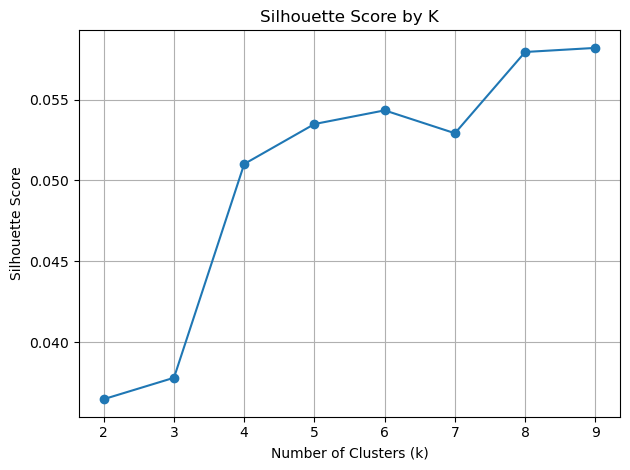

In [14]:
### Silhouette Score, which measures how well each data point fits within its cluster ###

# Why This Matters: A higher silhouette score indicates more well-defined clusters.
    # Helps avoid underfitting (too few clusters) or overfitting (too many clusters).
    # Efficiently identifies the number of behavior-based groupings present in technician notes.

# Method: Used TF-IDF transformed technician notes as input.
    # To reduce computation time, Sampled 5,000 notes from the full dataset.
    # For each value of k from 2 to 9:
    # Applied KMeans clustering.
    # Calculated the silhouette score.
    # Plotted the results to visualize the best k.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Sample the data to speed up calculations
sample_size = 5000  
if X_notes.shape[0] > sample_size:
    sample_indices = np.random.choice(X_notes.shape[0], sample_size, replace=False)
    X_sample = X_notes[sample_indices]
else:
    X_sample = X_notes

# Run silhouette scores for different k
scores = []
ks = range(2, 10)
for k in ks:
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=200, random_state=42)
    labels = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    scores.append(score)

# Plot results
plt.plot(ks, scores, marker='o')
plt.title('Silhouette Score by K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()



In [15]:
# Cluster Examples for clarity of what model is fitting the dataset
for i in range(5):  # or your new k
    print(f"\nCluster {i} Example Notes:\n")
    print(df[df['Note_Cluster'] == i]['Text'].sample(3, random_state=42).to_string(index=False))



Cluster 0 Example Notes:

      MEGOHM READING: 0.001---TAKEN ON 1/29/2021
FOUND DEBRIS UNDER SOUTH SIDE TUBE GUIDE.  W.FOX
                                  MOVED BY CLIFF

Cluster 1 Example Notes:

                                    REPLACED WIRES
ORDERED A RELAY BOARD.  BRAD  REPLACED BOARD.  ...
   turned oiler all the way down replaced air line

Cluster 2 Example Notes:

COMPLETE.  BRAD
       complete
       COMPLETE

Cluster 3 Example Notes:

                         REPAIRED BROKEN ASSEMBLY.
REPAIRED BROKEN FITTINGS ON UV SCANNER BUT MAY ...
two old florecent lights where broken hanging f...

Cluster 4 Example Notes:

     DISASSEMBLED AND REPAIRED    BOB/CD
                               REPAIRED.
REPAIRED PLUMBING AND REPLACED STRAINER.


In [16]:
### TF-IDF Vectorization for Descriptions ###
#Process: Transform work order descriptions into numerical features using TF-IDF to prepare for similarity analysis.

#Steps: Fill missing values in Description_cleaned.
#Filter for rows with technician notes (Text not empty).
#Apply TfidfVectorizer to convert text into weighted word vectors.
#Store TF-IDF matrix for future cosine similarity comparisons.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Cleaned description column
descriptions = df['Description_cleaned'].fillna("")

# Fit TF-IDF on all descriptions
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(descriptions)
# Only use rows with actual technician notes
df_notes_only = df[df['Text'].notna() & (df['Text'].str.strip() != "")]

# Fit TF-IDF on just these descriptions
descriptions = df_notes_only['Description_cleaned'].fillna("")
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(descriptions)


In [17]:
# Defining parameters for Find Machine/equipment no. Failure for fix 
def find_me_fix(input_description, top_n=10):
    desc_clean = input_description.lower().strip()
    input_vec = tfidf_vectorizer.transform([desc_clean])
    similarities = cosine_similarity(input_vec, tfidf_matrix).flatten()
    top_indices = similarities.argsort()[-top_n:][::-1]
    
    return df_notes_only.iloc[top_indices][['Description', 'Text', 'WO No.']]


In [18]:
# Find Machine/equipment no. Failure for fix 
find_me_fix("conveyor not working")

,Description,Text,WO No.
12650,CONVEYOR NOT WORKING,TURNED CURRENT UP ON DRIVE & PUT BELT TIGHTENE...,20033463
41426,CONVEYOR NOT WORKING,ADJUSTED REED SWITCH ON CLAMP. CHAD,20120500
34630,CONVEYOR NOT WORKING,CLEARED BOB,20104633
20828,CONVEYOR NOT WORKING,REPLACED MOTOR BEARINGS AND INSTALLED A TEFLON...,20062338
30889,CONVEYOR NOT WORKING,JOGGED IN REVERSE THEN RAN FINE. MD,20094603
12094,CONVEYOR NOT WORKING,E-STOP WAS PUSHED IN. BRAD,20032527
39015,CONVEYOR NOT WORKING,FOUND PROBLEM IN E-STOP CIRCUIT CORRECTED BOB,20113629
57458,CONVEYOR NOT WORKING,REPLACED SENSOR ON THE SOUTH BACK GATE ON SQUARE,20160487
45983,CONVEYOR NOT WORKING,HAD A TRIPPED BREAKER,20132018
13593,CONVEYOR NOT WORKING,"LS6 NOT MADE FRONT FIXTURE FULLY UP, FRONT FIX...",20040170


In [19]:
# Example Prediction Test:
description_input = "machine won't start after power outage"
predicted_cluster = pipeline.predict([description_input])[0]

print("Predicted Cluster:", predicted_cluster)
print(df[df['Note_Cluster'] == predicted_cluster]['Text_cleaned'].sample(5, random_state=42))

Predicted Cluster: 0
74403                  megohm reading 0001taken on 1292021
25939       found debris under south side tube guide  wfox
72311                                       moved by cliff
50171    talked to randy no new problems the filters ha...
78938               adjusted sensor distance from conveyor
Name: Text_cleaned, dtype: object


In [20]:
# Defining Prediction Parameters
from sklearn.metrics.pairwise import cosine_similarity

# Vectorize the description_input
input_vec = pipeline.named_steps['tfidf'].transform([description_input])

# Get all matching entries in the predicted cluster
cluster_notes = df[df['Note_Cluster'] == predicted_cluster]
cluster_vecs = pipeline.named_steps['tfidf'].transform(cluster_notes['Description_cleaned'])

# Measure similarity
sims = cosine_similarity(input_vec, cluster_vecs).flatten()
top_indices = sims.argsort()[-5:][::-1]

# Show best matching notes
top_matches = cluster_notes.iloc[top_indices]['Text_cleaned']

def get_predictions(description_input, pipeline, df, top_n=5):
    """
    Given a work order description, predicts the note cluster and returns
    the top_n most similar technician notes from that cluster.
    
    Parameters:
        description_input (str): The new work order description
        pipeline (sklearn.Pipeline): Your trained TF-IDF + classifier pipeline
        df (pd.DataFrame): The DataFrame with 'Description_cleaned', 'Text_cleaned', and 'Note_Cluster'
        top_n (int): Number of similar notes to return (default is 5)
        
    Returns:
        List of top_n matching notes (strings)
    """
    
    # Predict the most likely note cluster
    predicted_cluster = pipeline.predict([description_input])[0]
    
    # Filter DataFrame for that cluster
    cluster_df = df[df['Note_Cluster'] == predicted_cluster]
    
    # TF-IDF vectorize the input description
    input_vec = pipeline.named_steps['tfidf'].transform([description_input])
    
    # TF-IDF vectorize the descriptions in the predicted cluster
    cluster_vecs = pipeline.named_steps['tfidf'].transform(cluster_df['Description_cleaned'])
    
    # Cosine similarity
    similarities = cosine_similarity(input_vec, cluster_vecs).flatten()
    
    # Top N matches
    top_indices = similarities.argsort()[-top_n:][::-1]
    
    # Pull and return the matching notes
    top_matches = cluster_df.iloc[top_indices][['Description', 'Text_cleaned', 'WO No.']]
    
    print(f" Predicted Cluster: {predicted_cluster}")
    print(f"Input Description: {description_input}")
    print(f" Top {top_n} Similar Notes in This Cluster:\n")
    
    for i, row in top_matches.iterrows():
        print(f"- WO #{row['WO No.']}: {row['Text_cleaned']}")
    
    return top_matches


In [21]:
### 'problem - solution' prediction model get_predictions ###
get_predictions(
    description_input="machine won't turn on", 
    pipeline=pipeline, 
    df=df, 
    top_n=5
)


 Predicted Cluster: 0
Input Description: machine won't turn on
 Top 5 Similar Notes in This Cluster:

- WO #20084986: cleaned scanner spark igniter and reseated flame control  brad
adjusted air and air switch payne replaced pilot assembly payne
- WO #20162695: the disconnect is wore out
- WO #20115480: 24 volt power supply bad  ordered a new one  brad  installed new 24volt 20 amp dc power supply  brad
- WO #20094577: power supply is bad  ordered a new one  wfox  installed a new control will try to repair old one curt
- WO #20225528: some how a breaker was tripped for the plc and the battery must have been bad and it lost the program we had to get a copy from racine and redownload program


,Description,Text_cleaned,WO No.
27760,BOILER WON' T ON THE EDP.,cleaned scanner spark igniter and reseated fla...,20084986
59657,MACHINE WILL NOT TURN ON,the disconnect is wore out,20162695
40401,MACHINE WILL NOT TURN ON.,24 volt power supply bad ordered a new one b...,20115480
30863,"MACHINE WON'T TURN ON, REPAIR",power supply is bad ordered a new one wfox ...,20094577
82387,FIN MACHINE WILL NOT TURN ON,some how a breaker was tripped for the plc and...,20225528
